In [1]:
import torch 
import numpy as np 
import VirusDataset 
import ioutils 
import random 
import pickle
import pandas as pd
import torch.utils
from torch.utils.data import DataLoader
import pytorch_lightning as L
import importlib 
importlib.reload(VirusDataset)

/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'VirusDataset' from '/home/tyfei/ionChannel/VirusDataset.py'>

In [2]:
import random
random.seed(1509)
torch.manual_seed(1509)

In [16]:
import json
import os
import trainUtils 
path = "/home/tyfei/ionChannel/ckptsesm3/Lora5onlyseq/"
with open(os.path.join(path, "config.json"), "r") as f:
    configs = json.load(f)

pretrain_model = trainUtils.loadPretrainModel(configs) 
model = trainUtils.buildModel(configs, pretrain_model, "/home/tyfei/ionChannel/ckptsesm3/Lora5onlyseq/last.ckpt")

In [29]:
from tqdm import tqdm
def getEmbeddings(model, dl, device, trunc=30000):
    res = [] 
    model = model.to(device)
    model.eval()
    pbar = tqdm(dl)
    cnt = 0
    for i, j in enumerate(pbar):
        cnt += 1
        if cnt == trunc:
            break
        
        for track in ["sequence_t", "structure_t", "ss8_t", "sasa_t"]:
            if track not in j:
                j[track] = None
            else:
                j[track] = j[track].to(device)
                if len(j[track].size()) == 1:
                    j[track] = j[track].unsqueeze(0)
        
        representations = model(
            sequence_tokens=j["sequence_t"],
            structure_tokens=j["structure_t"],
            ss8_tokens=j["ss8_t"],
            sasa_tokens=j["sasa_t"],
        )
        representations = representations.embeddings.mean(axis=0) 
        res.append(representations.cpu().numpy()) 
    return res


In [30]:
pos = ["/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Archaea.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Bacteria.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Eukaryota.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/interpro.pkl",
        "/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/profile.pkl"
    ]
neg = ["/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/refseq_rmdup_mmseq_noTMHMM.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/refseq_rmdup_mmseq_TMHMM_keywords.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/virus_proteins_rmdup_clean_X0.1_TMHMM_mmseq_keywords_norefseq.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/interpro_neg.pkl"
    ]
test = ["/data/yangziyue/Ion_channel/data/TEST_refseq_rmdup_mmseq_TMHMM.pkl"]

In [31]:
embeds = [] 
labels = [] 

In [33]:
for i in pos:
    name = os.path.basename(i)
    name = name[:name.find(".")]
    print(i, name)
    if os.path.exists("./temp/%s_ori.pkl"%name):
        continue
    test = trainUtils.loadPickle(i)
    test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
    dl = DataLoader(test_set, batch_size=1, shuffle=False) 
    with torch.no_grad():
        t = getEmbeddings(pretrain_model, dl, "cuda:0")
        embeds.extend(t) 
        labels.extend([name]*len(test))
    with open("./temp/%s_ori.pkl"%name, "wb") as f:
        pickle.dump(t, f)
        
for i in neg:
    name = os.path.basename(i)
    name = name[:name.find(".")]
    print(i, name)
    if os.path.exists("./temp/%s_ori.pkl"%name):
        continue
    test = trainUtils.loadPickle(i)
    test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
    dl = DataLoader(test_set, batch_size=1, shuffle=False) 
    with torch.no_grad():
        t = getEmbeddings(pretrain_model, dl, "cuda:0")
        embeds.extend(t) 
        labels.extend([name]*len(test))
    with open("./temp/%s_ori.pkl"%name, "wb") as f:
        pickle.dump(t, f)
        
for i in test:
    name = os.path.basename(i)
    name = name[:name.find(".")]
    print(i, name)
    if os.path.exists("./temp/%s_ori.pkl"%name):
        continue
    test = trainUtils.loadPickle(i)
    test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
    dl = DataLoader(test_set, batch_size=1, shuffle=False) 
    with torch.no_grad():
        t = getEmbeddings(pretrain_model, dl, "cuda:0")
        embeds.extend(t) 
        labels.extend([name]*len(test))
    with open("./temp/%s_ori.pkl"%name, "wb") as f:
        pickle.dump(t, f)


/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Archaea.pkl Archaea
/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Bacteria.pkl Bacteria
/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Eukaryota.pkl Eukaryota
/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/interpro.pkl interpro
/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/profile.pkl profile
/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/refseq_rmdup_mmseq_noTMHMM.pkl refseq_rmdup_mmseq_noTMHMM
/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/refseq_rmdup_mmseq_TMHMM_keywords.pkl refseq_rmdup_mmseq_TMHMM_keywords
/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/virus_proteins_rmdup_clean_X0.1_TMHMM_mmseq_keywords_norefseq.pkl virus_proteins_rmdup_clean_X0
/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/interpro_neg.pkl interpro_neg
/home/tyfei/datasets/ion_channel/Interprot/Negativ

100%|██████████| 18466/18466 [20:35<00:00, 14.94it/s]


In [49]:
q = np.array(embeds)
q.shape

(44927, 1536)

In [50]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=30) 
pca_seq = pca.fit_transform(q)
pca_seq.shape
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(pca_seq)

In [51]:
df = pd.DataFrame({"x":X_embedded[:, 0], "y":X_embedded[:, 1], "label":labels})
# df["class"] = df["label"].map({1:"Ion channel", 0:"non ion channel", 2:"Virus"})
df.head()

,x,y,label
0,-14.433861,18.999802,Viruses
1,-66.919785,7.222468,Viruses
2,-7.128510,-81.100151,Viruses
3,-66.961456,-58.365158,Viruses
4,-87.206421,-2.171012,Viruses


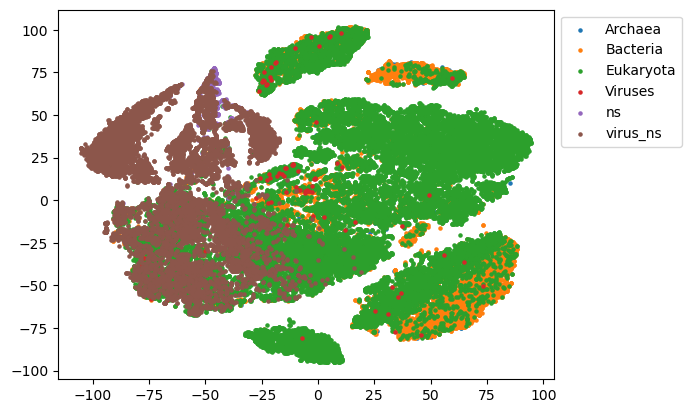

In [54]:
import matplotlib.pyplot as plt
for i in np.unique(df["label"]):
    subdf = df[df["label"] == i]
    plt.scatter(subdf["x"], subdf["y"], label=i, s=5)
plt.legend(bbox_to_anchor=(1,1))

In [23]:

# testdata = trainUtils.loadPickle("/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/virus_proteins_TMHMM_keywords.pkl")
# testdata = trainUtils.loadPickle("/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/interpro_neg.pkl")
testdata = trainUtils.loadPickle("/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Viruses.pkl")
# step_points = configs["augmentation"]["step_points"]
# crop = configs["augmentation"]["crop"]
# maskp = [
#     (i, j)
#     for i, j in zip(
#         configs["augmentation"]["maskp"], configs["augmentation"]["maskpc"]
#     )
# ]
# aug = VirusDataset.DataAugmentation(step_points, maskp, crop, lens)
print(len(testdata))
test_set = VirusDataset.ESM3MultiTrackDatasetTEST(testdata, tracks=["seq_t"]) 

dl = DataLoader(test_set, batch_size=1, shuffle=False) 

122


In [20]:
testdata[3].keys()

dict_keys(['randomseed', 'model', 'id', 'ori_seq', 'seq_t', 'second_t', 'sasa_t', 'coordinates', 'origin', 'structure_t'])

In [24]:
trainer = L.Trainer(accelerator="gpu", devices=[3]) 
res = trainer.predict(model, dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 122/122 [00:06<00:00, 18.57it/s]


(array([30., 10.,  4.,  1.,  5.,  2.,  0.,  5., 12., 53.]),
 array([0.00141849, 0.10094205, 0.20046562, 0.29998919, 0.39951274,
        0.49903631, 0.59855986, 0.69808346, 0.797607  , 0.89713061,
        0.99665415]),
 <BarContainer object of 10 artists>)

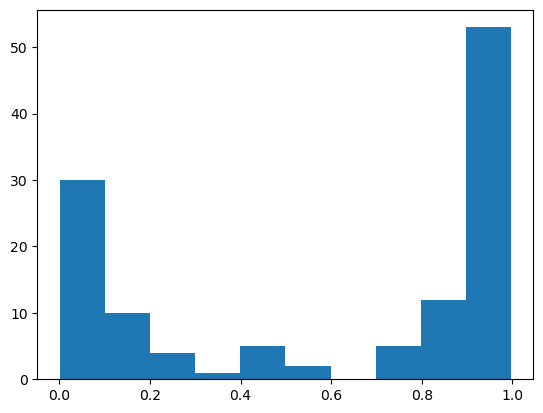

In [25]:
pre = torch.stack(res).numpy()
len(pre)
import matplotlib.pyplot as plt
plt.hist(pre)

(array([8839.,  297.,  137.,   80.,   70.,   55.,   43.,   69.,   74.,
          28.]),
 array([0.00140808, 0.10092815, 0.20044823, 0.2999683 , 0.39948839,
        0.49900848, 0.59852856, 0.69804859, 0.79756868, 0.89708877,
        0.99660885]),
 <BarContainer object of 10 artists>)

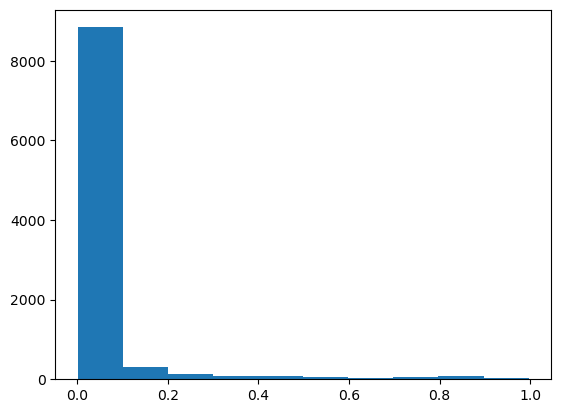

In [22]:
pre = torch.stack(res).numpy()
len(pre)
import matplotlib.pyplot as plt
plt.hist(pre)

(array([12.,  9.,  6.,  3., 12.,  3.,  6.,  1.,  4., 66.]),
 array([0.00230605, 0.10174943, 0.2011928 , 0.30063617, 0.40007955,
        0.49952292, 0.5989663 , 0.69840968, 0.79785305, 0.89729643,
        0.9967398 ]),
 <BarContainer object of 10 artists>)

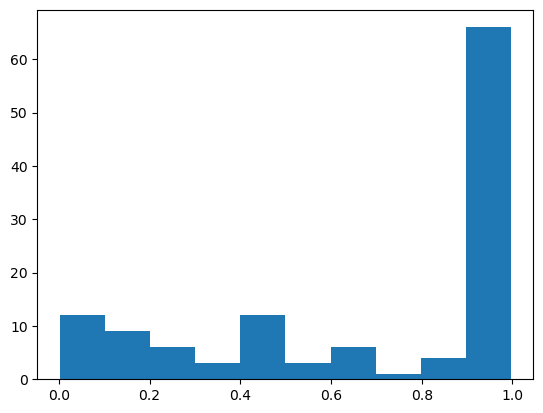

In [15]:
pre = torch.stack(res).numpy()
len(pre)
import matplotlib.pyplot as plt
plt.hist(pre)

(array([5591.,  690.,  411.,  333.,  450.,  400.,  358.,  383.,  371.,
         705.]),
 array([0.00228902, 0.10173409, 0.20117915, 0.30062422, 0.4000693 ,
        0.49951434, 0.59895945, 0.69840449, 0.79784954, 0.89729464,
        0.99673969]),
 <BarContainer object of 10 artists>)

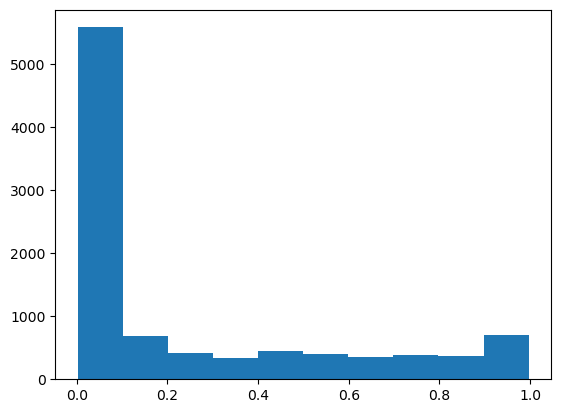

In [12]:
pre = torch.stack(res).numpy()
len(pre)
import matplotlib.pyplot as plt
plt.hist(pre)

(array([5546.,  535.,  299.,  210.,  221.,  185.,  203.,  290.,  613.,
        1590.]),
 array([0.00207064, 0.10166105, 0.20125145, 0.30084187, 0.40043226,
        0.50002265, 0.59961307, 0.69920349, 0.79879391, 0.89838427,
        0.99797469]),
 <BarContainer object of 10 artists>)

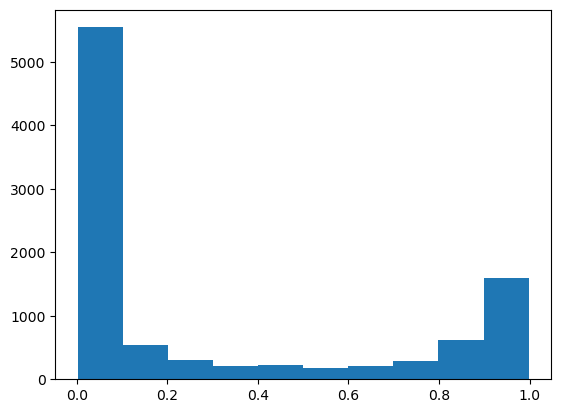

In [20]:
#Lora5mean
pre = torch.stack(res).numpy()
len(pre)
import matplotlib.pyplot as plt
plt.hist(pre)

(array([2394.,  514.,  303.,  264.,  243.,  277.,  274.,  337.,  742.,
        4344.]),
 array([0.00120502, 0.1009583 , 0.20071156, 0.30046484, 0.40021813,
        0.49997139, 0.59972465, 0.69947791, 0.79923123, 0.89898449,
        0.99873775]),
 <BarContainer object of 10 artists>)

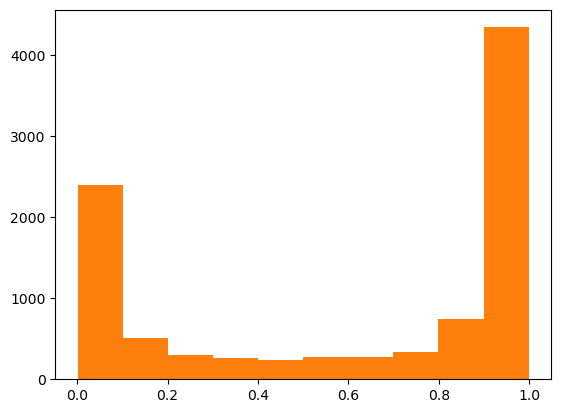

In [16]:
import matplotlib.pyplot as plt
plt.hist(pre)

(array([3793.,  545.,  359.,  300.,  209.,  243.,  266.,  377.,  724.,
        2876.]),
 array([0.00154487, 0.10118137, 0.20081787, 0.30045438, 0.40009087,
        0.49972737, 0.59936386, 0.69900036, 0.79863685, 0.89827335,
        0.99790984]),
 <BarContainer object of 10 artists>)

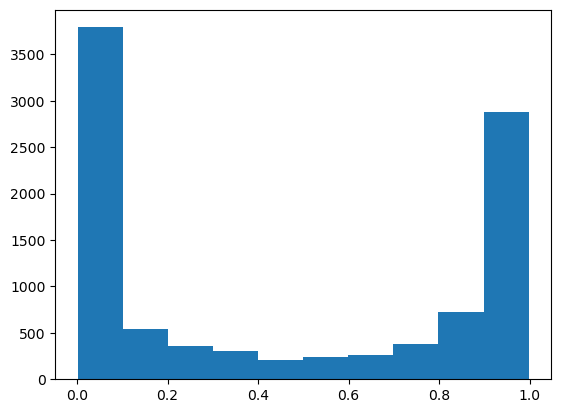

(array([422.,   2.,   1.,   2.,   0.,   1.,   1.,   0.,   1.,   1.]),
 array([0.00154836, 0.10029714, 0.19904591, 0.2977947 , 0.39654347,
        0.49529225, 0.59404105, 0.69278979, 0.7915386 , 0.89028734,
        0.98903614]),
 <BarContainer object of 10 artists>)

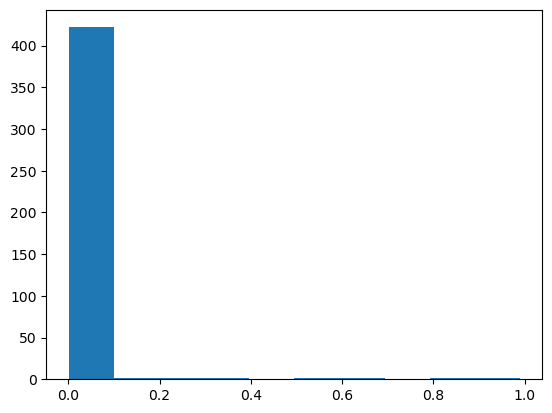

In [18]:
import matplotlib.pyplot as plt
plt.hist(pre)

(array([2.775e+03, 2.000e+01, 8.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        3.000e+00, 2.000e+00, 5.000e+00, 3.000e+00]),
 array([0.00154398, 0.09642326, 0.19130255, 0.28618184, 0.38106111,
        0.47594041, 0.57081968, 0.66569895, 0.76057827, 0.85545754,
        0.95033681]),
 <BarContainer object of 10 artists>)

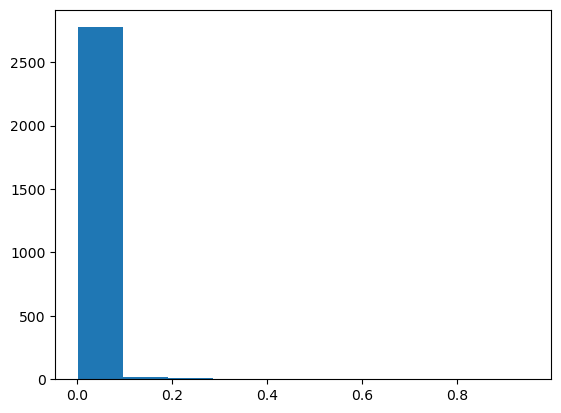

In [14]:
import matplotlib.pyplot as plt
plt.hist(pre)

(array([16.,  5.,  4.,  0.,  1.,  4.,  0.,  5.,  4., 83.]),
 array([0.00157986, 0.10121261, 0.20084538, 0.30047813, 0.40011087,
        0.49974364, 0.59937638, 0.69900912, 0.79864192, 0.89827466,
        0.9979074 ]),
 <BarContainer object of 10 artists>)

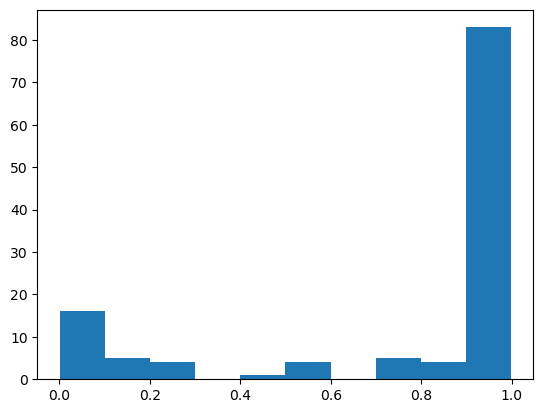

In [9]:
import matplotlib.pyplot as plt
plt.hist(pre)

In [44]:
pre = torch.concatenate(res).numpy()
len(pre)

678063

In [46]:
ids = [] 
dess = [] 
oris = []
for (id, des, ori) in X2_labels:
    ids.append(id)
    dess.append(des)
    oris.append(ori)
df = pd.DataFrame({"id":ids, "description":dess, "origanism":oris, "predict":pre})
df.head()

,id,description,origanism,predict
0,YP_009026398.1,"Arhar cryptic virus-I segment RNA-3, strain Hy...",ORGANISM Arhar cryptic virus-I Viruses. .,0.019432
1,YP_009956140.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.018958
2,YP_009956141.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.029809
3,YP_009956142.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.032612
4,YP_009956143.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.040137


In [59]:
df.to_csv("./temp/lora3contiune.csv")

In [50]:
phage = np.array(["phage" in name for name in df["origanism"]])
phage, np.sum(phage)

(array([False,  True,  True, ..., False, False, False]), 541006)

In [51]:
virusdf = df[~phage]

In [25]:
len(virusdf), sum(virusdf["is"])

(137057, 12992)

In [52]:
virusdf[virusdf["predict"] > 0.985]

,id,description,origanism,predict
3054,YP_009091851.1,"Erinnyis ello granulovirus, complete genome",ORGANISM Erinnyis ello granulovirus Viruses; ...,0.993528
3088,YP_009091885.1,"Erinnyis ello granulovirus, complete genome",ORGANISM Erinnyis ello granulovirus Viruses; ...,0.985456
3095,YP_009091892.1,"Erinnyis ello granulovirus, complete genome",ORGANISM Erinnyis ello granulovirus Viruses; ...,0.985354
3144,YP_009091941.1,"Erinnyis ello granulovirus, complete genome",ORGANISM Erinnyis ello granulovirus Viruses; ...,0.991594
3327,YP_004598986.1,"Cavally virus, complete genome",ORGANISM Cavally virus Viruses; Riboviria; Or...,0.986788
...,...,...,...,...
677592,YP_308941.1,"Trichoplusia ni SNPV, complete genome",ORGANISM Trichoplusia ni single nucleopolyhed...,0.995656
677633,YP_308982.1,"Trichoplusia ni SNPV, complete genome",ORGANISM Trichoplusia ni single nucleopolyhed...,0.985031
677737,YP_007378947.1,"Halovirus HVTV-1, complete genome",ORGANISM Haloarcula vallismortis tailed virus...,0.990092
677743,YP_007378953.1,"Halovirus HVTV-1, complete genome",ORGANISM Haloarcula vallismortis tailed virus...,0.989788


In [55]:
df["is"] = df["predict"] > 0.90
subdf = df[df["is"]]
len(subdf), len(df)

(33929, 678063)

In [14]:
phage = ["phage" in name for name in subdf["origanism"]]
phage

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False

In [56]:
subdf[subdf["description"] != ""]

,id,description,origanism,predict,is
29,YP_009956168.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.900197,True
34,YP_009956173.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.976232,True
38,YP_009956177.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.972736,True
72,YP_009956211.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.928504,True
114,NP_932364.1,"Aeromonas phage 44RR2.8t, complete genome",ORGANISM Aeromonas phage 44RR2.8t Viruses; Du...,0.918274,True
...,...,...,...,...,...
677842,YP_007379052.1,"Halovirus HVTV-1, complete genome",ORGANISM Haloarcula vallismortis tailed virus...,0.960302,True
677870,YP_009664766.1,Passion fruit yellow mosaic virus polymerase p...,ORGANISM Passion fruit yellow mosaic virus Vi...,0.983582,True
677875,YP_009801309.1,"Klebsiella phage KP32_isolate 192, complete ge...",ORGANISM Klebsiella phage KP32_isolate 192 Vi...,0.926805,True
677910,YP_009801344.1,"Klebsiella phage KP32_isolate 192, complete ge...",ORGANISM Klebsiella phage KP32_isolate 192 Vi...,0.942260,True


In [19]:
from sklearn.metrics import classification_report
pre = [i[0] for i in res] 
y = [i[1] for i in res]
pre = torch.concatenate(pre).numpy() 
y = torch.concatenate(y).numpy() 
predict_label = (pre>0.5).astype(int) 
print(classification_report(y, predict_label, target_names=["non-ion", "ion"]))

              precision    recall  f1-score   support

     non-ion       0.98      0.95      0.96     10600
         ion       0.95      0.98      0.97     10738

    accuracy                           0.96     21338
   macro avg       0.97      0.96      0.96     21338
weighted avg       0.97      0.96      0.96     21338



In [15]:
import utils
seqs = {}
seqs["virus_seq"] = utils.readDataset("/home/tyfei/datasets/ion_channel/Known_Virus_Ion_pro/all_Known_Virus_Ion_pro.rename_0.99.fasta", trunc=1200)
filtered = []
labels = [] 

for i, tt in seqs.items():
    labels.extend([i]*len(tt))
    for name, seq in tt:
        if "*" in seq:
            filtered.append((name, seq[:-1].upper()))
        else:
            filtered.append((name, seq.upper()))

In [43]:
from tqdm import tqdm 
batch_labels, _, batch_tokens = batch_converter(filtered) 
allres = []
clsmodel = clsmodel.cuda(1)
batch_tokens = batch_tokens.to("cuda:1")
for i in tqdm(range(0,len(batch_tokens), 10)):
    with torch.no_grad():
        pre, _ = clsmodel(batch_tokens[i:i+10])
        # token_representations = results["representations"][12].cpu().numpy()
        allres.append(pre.squeeze().cpu().numpy())
allres = np.concatenate(allres, axis=0)

100%|██████████| 37/37 [00:06<00:00,  5.45it/s]


(array([ 73.,  24.,  14.,   5.,   6.,   6.,   9.,   5.,  15., 212.]),
 array([0.00142959, 0.10092105, 0.20041251, 0.29990396, 0.39939541,
        0.49888688, 0.5983783 , 0.69786978, 0.79736125, 0.89685267,
        0.99634415]),
 <BarContainer object of 10 artists>)

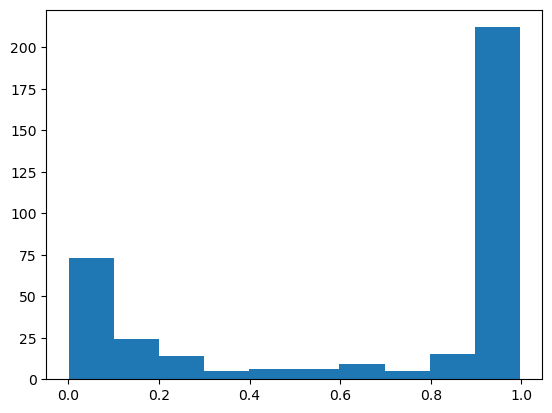

In [41]:
allres
import matplotlib.pyplot as plt
plt.hist(allres)

(array([100.,  21.,  28.,  20.,  11.,  10.,   4.,   7.,   3., 165.]),
 array([5.68135176e-04, 1.00103624e-01, 1.99639112e-01, 2.99174607e-01,
        3.98710102e-01, 4.98245597e-01, 5.97781062e-01, 6.97316587e-01,
        7.96852052e-01, 8.96387577e-01, 9.95923042e-01]),
 <BarContainer object of 10 artists>)

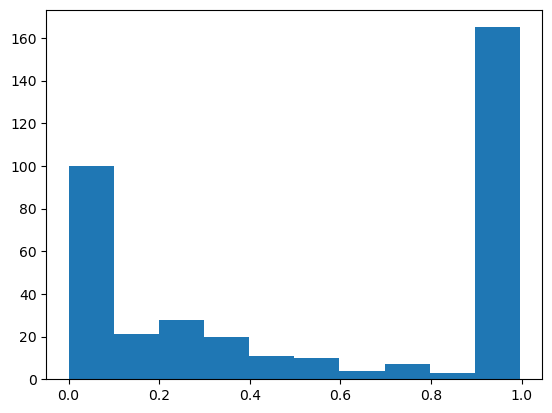

In [44]:
allres
import matplotlib.pyplot as plt
plt.hist(allres)

(array([ 93.,  10.,   9.,   9.,   8.,  19.,  18.,  34.,  45., 124.]),
 array([0.00586221, 0.10454156, 0.2032209 , 0.30190024, 0.40057957,
        0.49925894, 0.59793824, 0.6966176 , 0.79529697, 0.89397627,
        0.99265563]),
 <BarContainer object of 10 artists>)

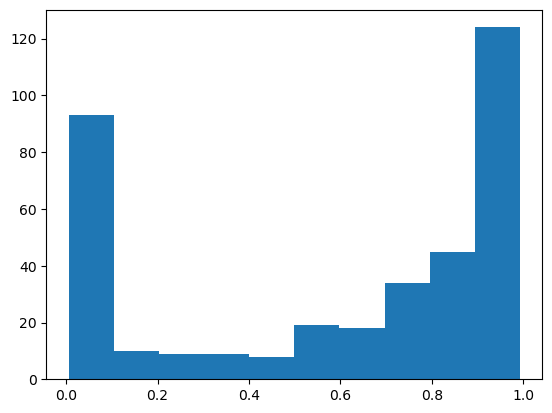

In [24]:
allres
import matplotlib.pyplot as plt
plt.hist(allres)

(array([ 38.,  38.,  11.,   5.,   7.,  10.,  15.,  16.,  24., 205.]),
 array([0.00870654, 0.10700988, 0.20531322, 0.30361658, 0.40191993,
        0.50022328, 0.5985266 , 0.69682997, 0.79513329, 0.89343667,
        0.99173999]),
 <BarContainer object of 10 artists>)

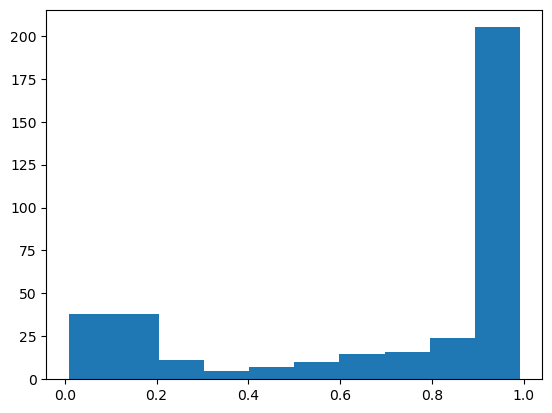

In [17]:
allres
import matplotlib.pyplot as plt
plt.hist(allres)

(array([ 51.,  11.,   5.,  13.,   8.,  12.,   7.,   8.,  12., 242.]),
 array([0.00578006, 0.10388525, 0.20199043, 0.30009562, 0.39820081,
        0.49630597, 0.59441119, 0.69251633, 0.79062152, 0.88872671,
        0.9868319 ]),
 <BarContainer object of 10 artists>)

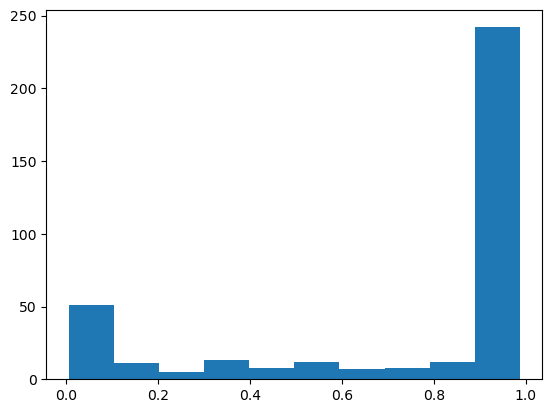

In [25]:
allres
import matplotlib.pyplot as plt
plt.hist(allres)